In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
figure(figsize=(20, 10), dpi=100)

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [69]:
aqi = pd.read_csv('avg_aqi_1988.csv')
aqi

,year,aqi,type,site
0,1988,42.040816,gas,48109
1,1989,52.355353,gas,48109
2,1990,43.050000,gas,48109
3,1991,45.778195,gas,48109
4,1992,49.482546,gas,48109
...,...,...,...,...
111,2019,27.211430,particle,35013
112,2020,34.055230,particle,35013
113,2021,31.054841,particle,35013
114,2022,24.690230,particle,35013


In [70]:
X_gas = aqi[aqi['type']=='gas'][aqi['site']==35013].reset_index(drop=True)
X_gas = X_gas.rename(columns={'year':'Year', 'aqi':'AQI_Gas'})
X_gas = X_gas.drop(columns=['type','site'])
X_gas.dtypes

C:\Users\wuron\AppData\Local\Temp\ipykernel_20892\1576295369.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_gas = aqi[aqi['type']=='gas'][aqi['site']==35013].reset_index(drop=True)


Year         int64
AQI_Gas    float64
dtype: object

In [71]:
X_particle = aqi[aqi['type']=='particle'][aqi['site']==35013].reset_index(drop=True)
X_particle = X_particle.rename(columns={'year':'Year', 'aqi':'AQI_Particle'})
X_particle = X_particle.drop(columns=['type','site'])
X_particle.dtypes

C:\Users\wuron\AppData\Local\Temp\ipykernel_20892\2231808903.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_particle = aqi[aqi['type']=='particle'][aqi['site']==35013].reset_index(drop=True)


Year              int64
AQI_Particle    float64
dtype: object

### Since we are looking at the fire season, we are extracting only data from May to October

In [72]:
df_discharge_m = pd.read_csv('month_discharge.csv')
df_discharge_m = df_discharge_m[df_discharge_m['month_nu']>=5][df_discharge_m['month_nu']<=10]
df_discharge_m.shape

C:\Users\wuron\AppData\Local\Temp\ipykernel_20892\3491926406.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_discharge_m = df_discharge_m[df_discharge_m['month_nu']>=5][df_discharge_m['month_nu']<=10]


(407, 8)

In [73]:
df_discharge_m = df_discharge_m.drop(columns=['agency_cd', 'site_no', 'ts_id', 'month_nu', 'parameter_cd'])
# df_discharge_m = df_discharge_m[df_discharge_m['year_nu']>=1988].reset_index(drop=True)
df_discharge_m = df_discharge_m.rename(columns={'year_nu':'Year', 'mean_va':'Mean_Water_Discharge', 'year_month':'Year_Month'})
X_discharge = df_discharge_m.groupby('Year')['Mean_Water_Discharge'].mean().reset_index()
X_discharge.dtypes


Year                      int64
Mean_Water_Discharge    float64
dtype: object

In [74]:
df_fire = pd.read_csv('wildfire_part2.csv')
X_fire = df_fire.drop(columns =['Listed_Fire_Dates','Listed_Fire_Start']).rename(columns={'Fire_Year':'Year'})
cnt = X_fire.groupby(by='Year').count()['GIS_Acres'].reset_index().rename(columns={'GIS_Acres':'Count'})
X_fire = X_fire.groupby(by='Year').mean()[['avg_distance (miles)', 'GIS_Acres']].reset_index()
# X_fire = X_fire[X_fire['Year']>=1988].reset_index(drop=True)

In [75]:
X_fire = X_fire.merge(cnt, on='Year')

In [76]:
a = X_fire['avg_distance (miles)']
b = np.sqrt(X_fire['GIS_Acres'])
c = X_fire['Count']
X_fire['Estimator'] = pd.Series(b*c/np.sqrt(a))
# X_fire['Estimator'] = pd.Series(np.sqrt(500 * b / a))

In [77]:
X = X_fire.merge(X_discharge, on='Year').merge(X_particle, on='Year').merge(X_gas, on='Year')

In [78]:
X.corr()

,Year,avg_distance (miles),GIS_Acres,Count,Estimator,Mean_Water_Discharge,AQI_Particle,AQI_Gas
Year,1.000000,-0.345372,0.156831,0.884169,0.769965,-0.896961,-0.653230,0.198797
avg_distance (miles),-0.345372,1.000000,-0.183288,-0.485809,-0.491618,0.370138,0.049121,-0.024502
GIS_Acres,0.156831,-0.183288,1.000000,0.360672,0.579590,-0.015323,0.021260,-0.057018
Count,0.884169,-0.485809,0.360672,1.000000,0.958305,-0.767920,-0.487047,0.333101
Estimator,0.769965,-0.491618,0.579590,0.958305,1.000000,-0.638275,-0.401401,0.322108
Mean_Water_Discharge,-0.896961,0.370138,-0.015323,-0.767920,-0.638275,1.000000,0.574791,-0.196610
AQI_Particle,-0.653230,0.049121,0.021260,-0.487047,-0.401401,0.574791,1.000000,-0.153425
AQI_Gas,0.198797,-0.024502,-0.057018,0.333101,0.322108,-0.196610,-0.153425,1.000000


In [79]:
# df_a = pd.read_csv('Arsenic_Annual.csv')[['Year', 'Arsenic Concentrations (mcg/L)']]
# df_n = pd.read_csv('NI_Annual.csv')[['Year', 'Nitrate-System Means (mg/L)']]
# df_h = pd.read_csv('HAA5_Annual.csv')[['Year', 'HAA5-System Means (mcg/L)']] # since 2007
# df_t = pd.read_csv('TTHM_Annual.csv')[['Year', 'TTHM-System Means (mcg/L)']]

In [80]:
df_n = pd.read_csv('nitrate_qtr.csv')[['Quarter', 'Nitrate-System Means (mcg/L)']]
df_h = pd.read_csv('haa_qtr.csv')[['Quarter', 'HAA-SystemsCount (mcg/L)']] # since 2007

compounds = [df_n, df_h]
qtr_to_day = {' Jan-Mar':'-Q1',' Apr-Jun':'-Q2',' Jul-Sep':'-Q3',' Oct-Dec':'-Q4'}

for compound in compounds:
    compound['Year'] = compound['Quarter'].str[:4].astype('int64')
    for k,v in zip(qtr_to_day.keys(), qtr_to_day.values()):
        compound['Quarter'] = compound['Quarter'].str.replace(k, v)
    compound['Quarter'] = compound['Quarter'].str[-2:]

,Quarter,Atrazine-System Means (mcg/L),Year
0,Q3,0.10,2003
1,Q4,0.10,2003
2,Q1,0.10,2004
3,Q2,0.10,2004
4,Q3,0.10,2004
...,...,...,...
73,Q4,0.05,2021
74,Q1,0.05,2022
75,Q2,0.05,2022
76,Q3,0.05,2022


In [82]:
idx_q1 = df_n[df_n['Quarter']=='Q1'].index
df_n = df_n.drop(idx_q1, axis=0).reset_index(drop=True)
idx_q2 = df_n[df_n['Quarter']=='Q2'].index
idx_q3 = df_n[df_n['Quarter']=='Q3'].index
idx_q4 = df_n[df_n['Quarter']=='Q4'].index
tmp = []
for i in range(df_n.shape[0]):
    if i in idx_q2:
        tmp.append(2/6)
    elif i in idx_q3:
        tmp.append(3/6)
    elif i in idx_q4:
        tmp.append(1/6)
df_n['Weighted Nitrate Means (mcg/L)'] = tmp * df_n['Nitrate-System Means (mcg/L)']
df_n = df_n.groupby(by='Year')['Weighted Nitrate Means (mcg/L)'].sum().reset_index()

In [83]:
idx_q1 = df_h[df_h['Quarter']=='Q1'].index
df_h = df_h.drop(idx_q1, axis=0).reset_index(drop=True)
idx_q2 = df_h[df_h['Quarter']=='Q2'].index
idx_q3 = df_h[df_h['Quarter']=='Q3'].index
idx_q4 = df_h[df_h['Quarter']=='Q4'].index
tmp = []
for i in range(df_h.shape[0]):
    if i in idx_q2:
        tmp.append(2/6)
    elif i in idx_q3:
        tmp.append(3/6)
    elif i in idx_q4:
        tmp.append(1/6)
df_h['Weighted HAA Count (mcg/L)'] = tmp * df_h['HAA-SystemsCount (mcg/L)']
df_h = df_h.groupby(by='Year')['Weighted HAA Count (mcg/L)'].sum().reset_index()

In [86]:
# # check correlation on TTHM with fire/water discharge

# X_t = X.merge(df_t, on='Year')
# X_t.corr()

In [87]:
# y_t = X_t['Weighted TTHM Means (mcg/L)']
# X_t_sub = X_t.drop(columns=['Year', 'Weighted TTHM Means (mcg/L)', 'Mean_Water_Discharge'])

# X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t_sub, y_t, test_size=0.2, random_state=0)

# reg = LinearRegression().fit(X_t_train, y_t_train)
# print(reg.score(X_t_train, y_t_train))

In [88]:
# check correlation on HAA5 with fire/water discharge

X_h = X.merge(df_h, on='Year')
X_h.corr()

,Year,avg_distance (miles),GIS_Acres,Count,Estimator,Mean_Water_Discharge,AQI_Particle,AQI_Gas,Weighted HAA Count (mcg/L)
Year,1.000000,0.163897,0.083789,0.434887,0.289487,-0.736564,-0.239049,0.480056,0.372843
avg_distance (miles),0.163897,1.000000,-0.191620,-0.725557,-0.644836,0.110132,-0.355351,-0.205761,-0.219202
GIS_Acres,0.083789,-0.191620,1.000000,0.523088,0.779098,0.053079,0.008099,0.522981,0.412659
Count,0.434887,-0.725557,0.523088,1.000000,0.937348,-0.408774,0.146381,0.576464,0.550811
Estimator,0.289487,-0.644836,0.779098,0.937348,1.000000,-0.232676,0.145430,0.605691,0.558194
Mean_Water_Discharge,-0.736564,0.110132,0.053079,-0.408774,-0.232676,1.000000,0.094568,-0.524305,-0.279302
AQI_Particle,-0.239049,-0.355351,0.008099,0.146381,0.145430,0.094568,1.000000,-0.056110,-0.098744
AQI_Gas,0.480056,-0.205761,0.522981,0.576464,0.605691,-0.524305,-0.056110,1.000000,0.741473
Weighted HAA Count (mcg/L),0.372843,-0.219202,0.412659,0.550811,0.558194,-0.279302,-0.098744,0.741473,1.000000


In [89]:
y_h = X_h['Weighted HAA Count (mcg/L)']
X_h_sub = np.array(X_h['Estimator']).reshape(-1,1)
# X_h_sub = X_h.drop(columns=['Year', 'Weighted HAA Count (mcg/L)', 'Mean_Water_Discharge'])

X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h_sub, y_h, test_size=0.2, random_state=0)

reg_h = LinearRegression().fit(X_h_train, y_h_train)
print(reg_h.score(X_h_train, y_h_train))

0.3811279867662035


[0.00144697]
r2_score of HAAs: -1.9814009610335597
MSE of HAAs: 9.740218734172926


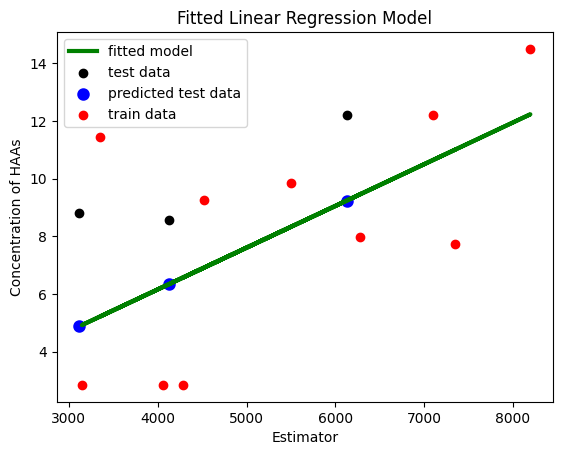

In [100]:
y_h_pred = reg_h.predict(X_h_test)
y_h_trainpred = reg_h.predict(X_h_train)
print(reg_h.coef_)
print('r2_score of HAAs:', r2_score(y_h_pred, y_h_test))
print('MSE of HAAs:', mean_squared_error(y_h_pred, y_h_test))

plt.scatter(X_h_test, y_h_test, color="black", label='test data')
plt.scatter(X_h_test, y_h_pred, color="blue", linewidth=3, label='predicted test data')
plt.scatter(X_h_train, y_h_train, color="red", label='train data')
plt.plot(X_h_train, y_h_trainpred, color="green", linewidth=3, label='fitted model')
plt.legend()
plt.xlabel('Estimator')
plt.ylabel('Concentration of HAAs')
# plt.xticks(())
# plt.yticks(())
plt.title('Fitted Linear Regression Model')
plt.show()

In [91]:
# check correlation on nitrate with fire/water discharge

X_n = X.merge(df_n, on='Year')
X_n.corr()

,Year,avg_distance (miles),GIS_Acres,Count,Estimator,Mean_Water_Discharge,AQI_Particle,AQI_Gas,Weighted Nitrate Means (mcg/L)
Year,1.000000,-0.272297,-0.077891,0.701488,0.495396,-0.656420,-0.531743,0.703251,0.338557
avg_distance (miles),-0.272297,1.000000,-0.033866,-0.705755,-0.623672,0.268148,-0.003397,-0.376722,-0.844739
GIS_Acres,-0.077891,-0.033866,1.000000,0.353412,0.648844,0.231226,0.093677,0.273784,-0.079851
Count,0.701488,-0.705755,0.353412,1.000000,0.933043,-0.357286,-0.279887,0.721753,0.669609
Estimator,0.495396,-0.623672,0.648844,0.933043,1.000000,-0.185373,-0.158859,0.670712,0.547337
Mean_Water_Discharge,-0.656420,0.268148,0.231226,-0.357286,-0.185373,1.000000,0.260715,-0.527422,-0.264754
AQI_Particle,-0.531743,-0.003397,0.093677,-0.279887,-0.158859,0.260715,1.000000,-0.295045,-0.167777
AQI_Gas,0.703251,-0.376722,0.273784,0.721753,0.670712,-0.527422,-0.295045,1.000000,0.379603
Weighted Nitrate Means (mcg/L),0.338557,-0.844739,-0.079851,0.669609,0.547337,-0.264754,-0.167777,0.379603,1.000000


In [92]:
y_n = X_n['Weighted Nitrate Means (mcg/L)']
X_n_sub = np.array(X_n['Estimator']).reshape(-1,1)
# X_n_sub = X_n.drop(columns=['Year', 'Weighted Nitrate Means (mcg/L)','Mean_Water_Discharge'])

X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n_sub, y_n, test_size=0.2, random_state=1)

reg_n = LinearRegression().fit(X_n_train, y_n_train)
print(reg_n.score(X_n_train, y_n_train))

0.3175752062259224


[0.00020119]
r2_score of nitrate: -0.6833934357269533
MSE of nitrate: 0.13163723010048178


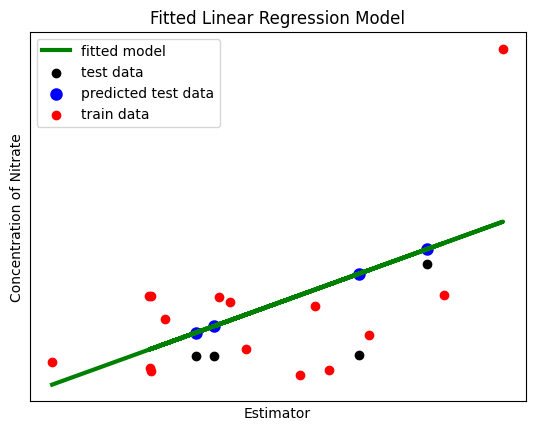

In [103]:
y_n_pred = reg_n.predict(X_n_test)
y_n_trainpred = reg_n.predict(X_n_train)
print(reg_n.coef_)
print('r2_score of nitrate:', r2_score(y_n_pred, y_n_test))
print('MSE of nitrate:', mean_squared_error(y_n_pred, y_n_test))

plt.scatter(X_n_test, y_n_test, color="black", label='test data')
plt.scatter(X_n_test, y_n_pred, color="blue", linewidth=3, label='predicted test data')
plt.scatter(X_n_train, y_n_train, color="red", label='train data')
plt.plot(X_n_train, y_n_trainpred, color="green", linewidth=3, label='fitted model')

plt.xlabel('Estimator')
plt.ylabel('Concentration of Nitrate')
plt.xticks(())
plt.yticks(())
plt.title('Fitted Linear Regression Model')
plt.legend()
plt.show()

In [96]:
temp_h = X_h[['Year', 'avg_distance (miles)', 'GIS_Acres', 'Count', 'AQI_Particle', 'AQI_Gas', 'Weighted HAA Count (mcg/L)']]
temp_h.corr()

,Year,avg_distance (miles),GIS_Acres,Count,AQI_Particle,AQI_Gas,Weighted HAA Count (mcg/L)
Year,1.000000,0.163897,0.083789,0.434887,-0.239049,0.480056,0.372843
avg_distance (miles),0.163897,1.000000,-0.191620,-0.725557,-0.355351,-0.205761,-0.219202
GIS_Acres,0.083789,-0.191620,1.000000,0.523088,0.008099,0.522981,0.412659
Count,0.434887,-0.725557,0.523088,1.000000,0.146381,0.576464,0.550811
AQI_Particle,-0.239049,-0.355351,0.008099,0.146381,1.000000,-0.056110,-0.098744
AQI_Gas,0.480056,-0.205761,0.522981,0.576464,-0.056110,1.000000,0.741473
Weighted HAA Count (mcg/L),0.372843,-0.219202,0.412659,0.550811,-0.098744,0.741473,1.000000


In [97]:
temp_n = X_n[['Year', 'avg_distance (miles)', 'GIS_Acres', 'Count', 'AQI_Particle', 'AQI_Gas', 'Weighted Nitrate Means (mcg/L)']]
temp_n.corr()

,Year,avg_distance (miles),GIS_Acres,Count,AQI_Particle,AQI_Gas,Weighted Nitrate Means (mcg/L)
Year,1.000000,-0.272297,-0.077891,0.701488,-0.531743,0.703251,0.338557
avg_distance (miles),-0.272297,1.000000,-0.033866,-0.705755,-0.003397,-0.376722,-0.844739
GIS_Acres,-0.077891,-0.033866,1.000000,0.353412,0.093677,0.273784,-0.079851
Count,0.701488,-0.705755,0.353412,1.000000,-0.279887,0.721753,0.669609
AQI_Particle,-0.531743,-0.003397,0.093677,-0.279887,1.000000,-0.295045,-0.167777
AQI_Gas,0.703251,-0.376722,0.273784,0.721753,-0.295045,1.000000,0.379603
Weighted Nitrate Means (mcg/L),0.338557,-0.844739,-0.079851,0.669609,-0.167777,0.379603,1.000000


In [98]:
X_sum = X_fire.merge(X_gas, on='Year').merge(X_particle, on='Year')
X_sum

,Year,avg_distance (miles),GIS_Acres,Count,Estimator,AQI_Gas,AQI_Particle
0,1988,874.046063,2644.958093,1540,2678.939822,41.727026,45.065934
1,1989,809.169977,1065.345442,1342,1539.848029,47.770985,41.400943
2,1990,916.973266,1157.738125,1111,1248.363003,45.487738,34.231293
3,1991,921.542034,994.774146,972,1009.882706,46.144928,30.590604
4,1992,906.282300,1313.456484,1092,1314.615455,45.471582,31.230263
5,1993,769.490757,1444.667459,778,1066.011374,40.892948,29.717608
6,1994,795.771653,2082.769560,1478,2391.116920,43.057671,36.331269
7,1995,811.682524,1185.823137,1208,1460.104019,41.313433,43.880952
8,1996,814.459041,3238.672284,1643,3276.320971,40.173756,34.680928
9,1997,841.172628,834.691347,897,893.537601,39.209158,30.126545


Text(0.5, 0, 'Year')

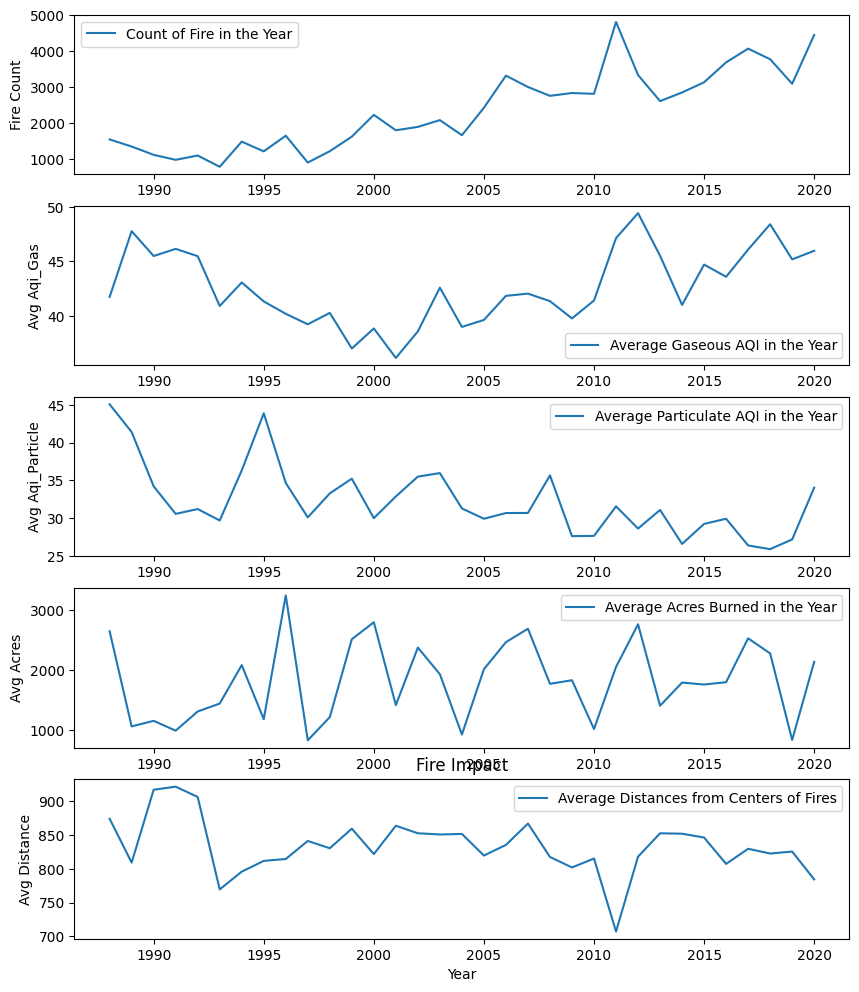

In [99]:
import numpy as np
from sklearn import preprocessing as pre

# x_count = np.array(X_sum['Count']).reshape(-1,1)
# x_count_norm = pre.MinMaxScaler().fit_transform(x_count)

# x_aqigas = np.array(X_sum['AQI_Gas']).reshape(-1,1)
# x_aqigas_norm = pre.MinMaxScaler().fit_transform(x_aqigas)

# x_aqip = np.array(X_sum['AQI_Particle']).reshape(-1,1)
# x_aqip_norm = pre.MinMaxScaler().fit_transform(x_aqip)

# x_acres = np.array(X_sum['GIS_Acres']).reshape(-1,1)
# x_acres_norm = pre.MinMaxScaler().fit_transform(x_acres)

# x_dist = np.array(X_sum['avg_distance (miles)']).reshape(-1,1)
# x_dist_norm = pre.MinMaxScaler().fit_transform(x_dist)
fig, ax = plt.subplots(5,1, figsize=(10,12))
# figure(figsize=(20,10), dpi=100)
ax[0].plot(X_sum['Year'], X_sum['Count'], label='Count of Fire in the Year')
ax[0].set_ylabel('Fire Count')
ax[0].legend()
ax[1].plot(X_sum['Year'], X_sum['AQI_Gas'], label='Average Gaseous AQI in the Year')
ax[1].set_ylabel('Avg Aqi_Gas')
ax[1].legend()
ax[2].plot(X_sum['Year'], X_sum['AQI_Particle'], label='Average Particulate AQI in the Year')
ax[2].set_ylabel('Avg Aqi_Particle')
ax[2].legend()
ax[3].plot(X_sum['Year'], X_sum['GIS_Acres'], label='Average Acres Burned in the Year')
ax[3].set_ylabel('Avg Acres')
ax[3].legend()
ax[4].plot(X_sum['Year'], X_sum['avg_distance (miles)'], label='Average Distances from Centers of Fires')
ax[4].set_ylabel('Avg Distance')
ax[4].legend()
plt.title('Fire Impact')
plt.xlabel('Year')